In [3]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Load datasets
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Merge customer and transaction data
data = pd.merge(transactions_df, customers_df, on='CustomerID')

In [5]:
# Aggregate transaction data by customer
customer_features = data.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean'],
    'TransactionID': 'count'
}).reset_index()

customer_features.columns = ['CustomerID', 'TotalSpend', 'AvgTransactionValue', 'TransactionCount']

In [6]:
# One-hot encode the Region feature
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_region = encoder.fit_transform(customers_df[['Region']])
encoded_region_df = pd.DataFrame(encoded_region, columns=encoder.get_feature_names_out(['Region']))

# Combine features into a single DataFrame
customer_features = pd.concat([customer_features, encoded_region_df], axis=1)

# Handle missing values
for column in customer_features.select_dtypes(include=np.number).columns:
    customer_features[column] = customer_features[column].fillna(customer_features[column].mean())

# Normalize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features.drop('CustomerID', axis=1))

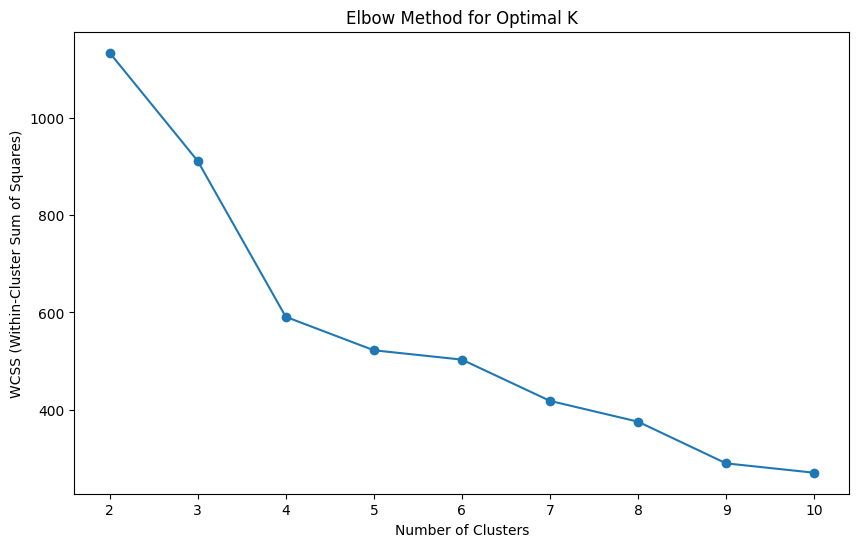

In [7]:
# Optimize the number of clusters using the Elbow method
wcss = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

Davies-Bouldin Index: 0.9310204834009101


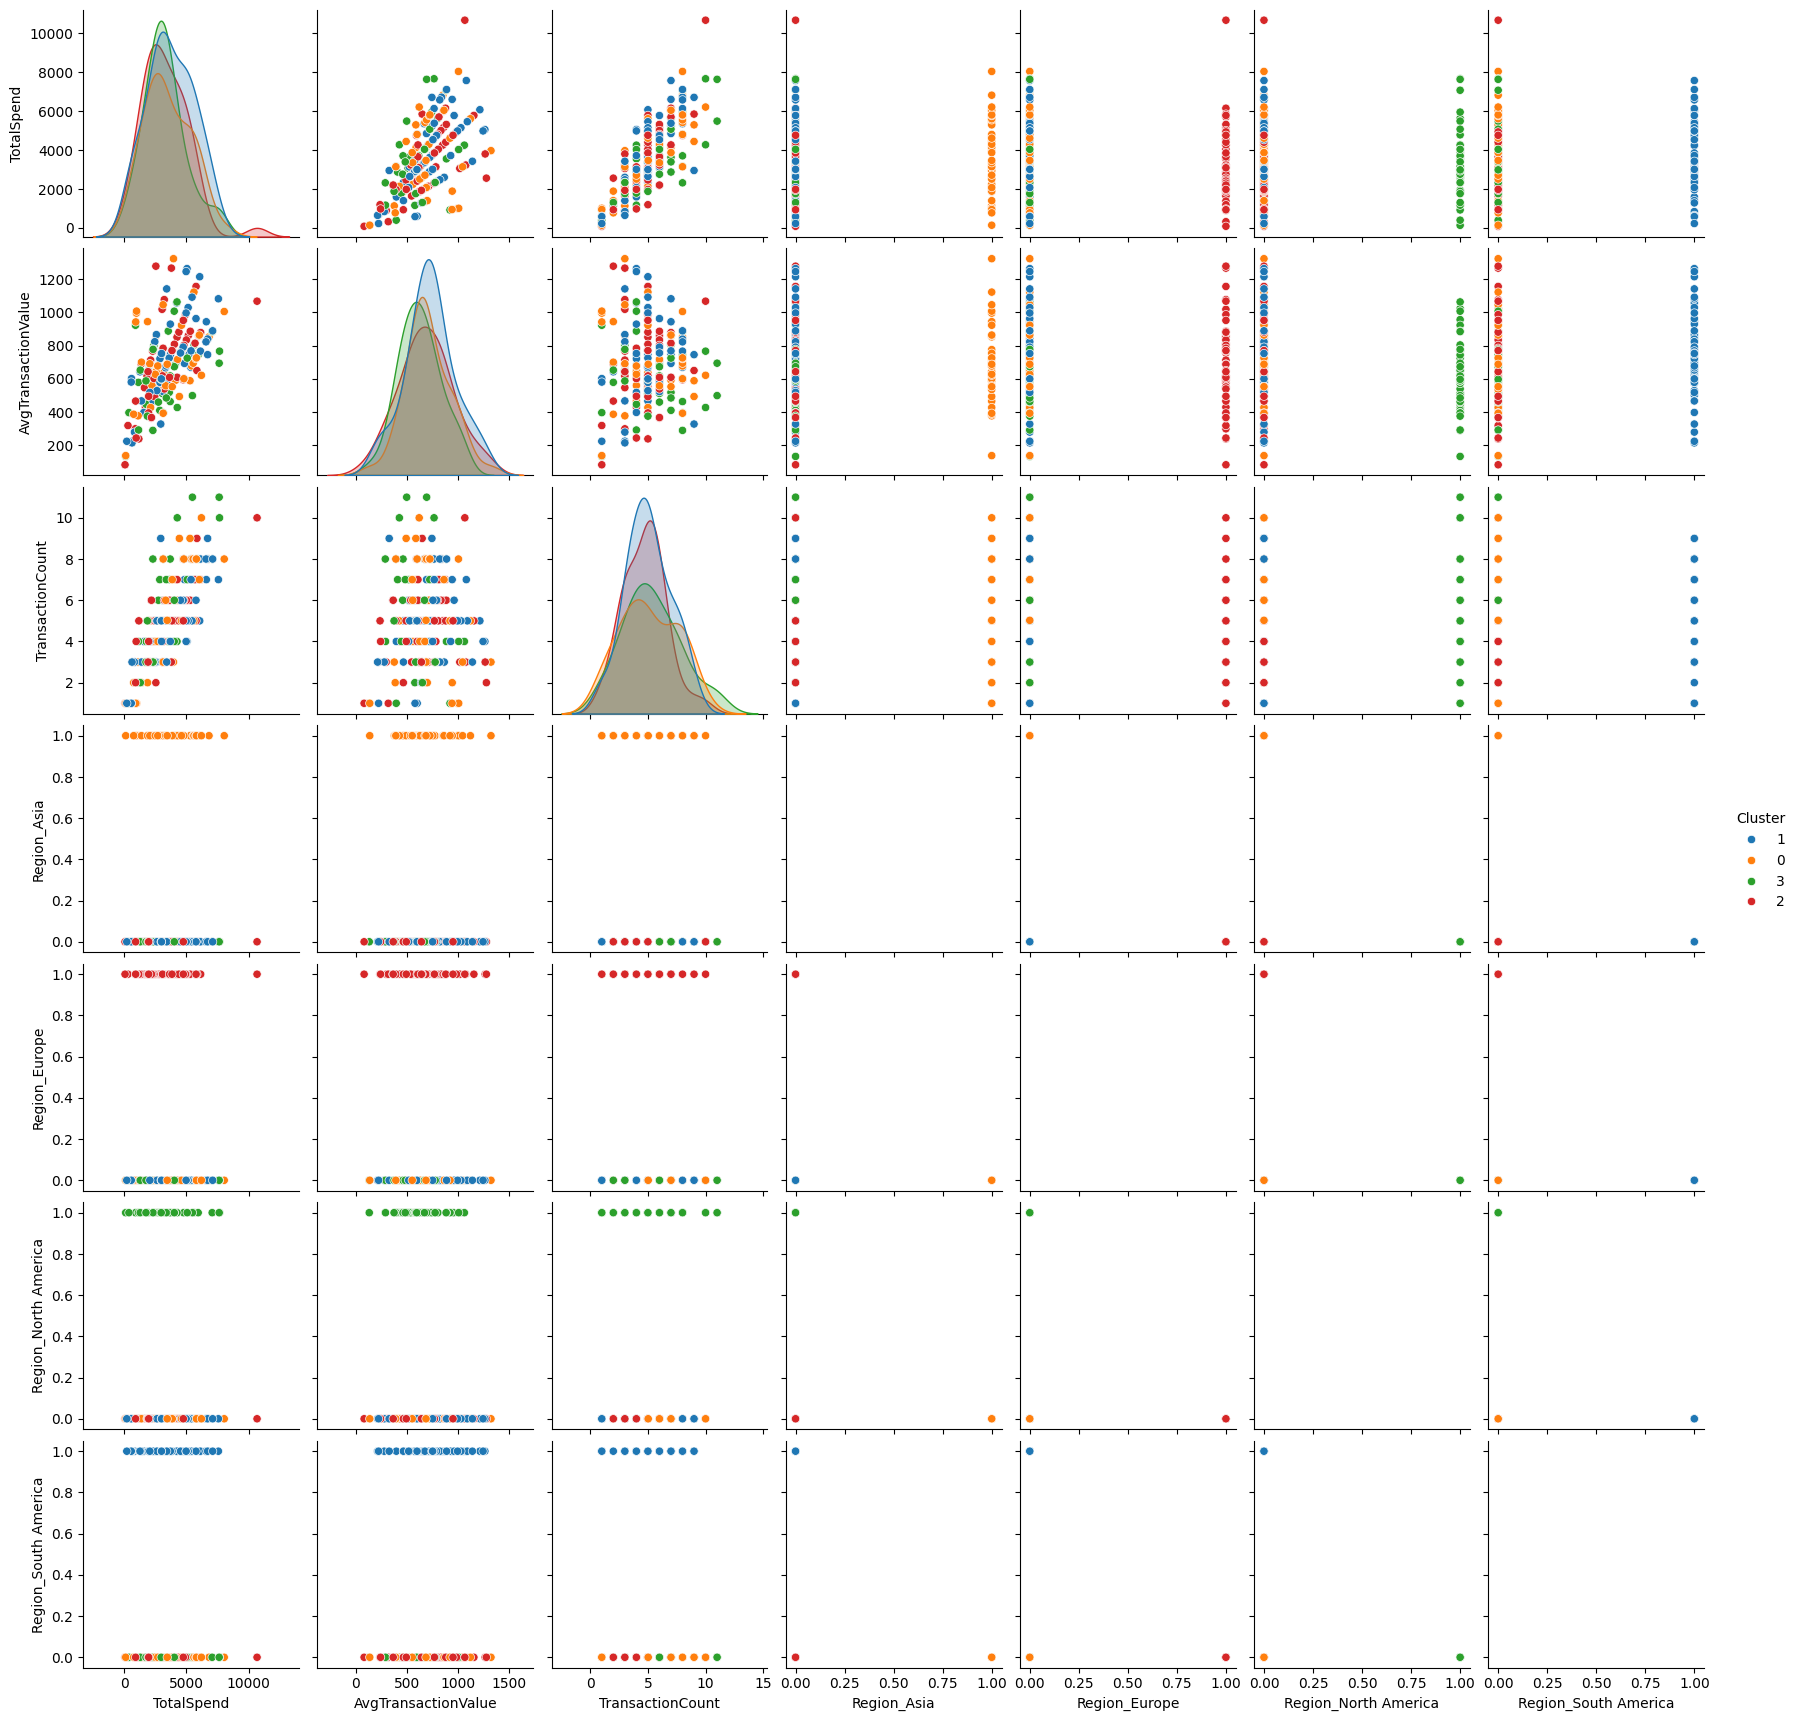

In [8]:
# Select the optimal number of clusters (user can adjust based on the Elbow plot)
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

# Assign cluster labels to customer features
customer_features['Cluster'] = cluster_labels

# Evaluate clustering using Davies-Bouldin Index
db_index = davies_bouldin_score(scaled_features, cluster_labels)
print(f'Davies-Bouldin Index: {db_index}')

# Visualize the clusters using a pair plot
customer_features_plot = customer_features.copy()
customer_features_plot['Cluster'] = customer_features_plot['Cluster'].astype(str)
sns.pairplot(customer_features_plot.drop('CustomerID', axis=1), hue='Cluster', palette='tab10')
plt.show()

In [9]:
# Save the clustering results
customer_features[['CustomerID', 'Cluster']].to_csv('Customer_Clusters.csv', index=False)

print("Clustering completed. Results saved in Customer_Clusters.csv.")

Clustering completed. Results saved in Customer_Clusters.csv.


CSV FILE : https://drive.google.com/file/d/1DV8qw7db_aurtROkhfDDe3y_QAEymaIY/view?usp=sharing